In [1]:
import numpy as np # numpy is magic
import pylab as plt # for plotting
import pandas as pd # to access csv files
import glob # access all files according to some keyword
import os
import sys
import imageio # to make the animations
# geopandas may have problems installing. Use a clean python environment
import geopandas as gpd # spatial plotting
import psycopg2
import matplotlib.ticker as plticker
%matplotlib inline  


# CALL IN FILES

In [2]:
# Access the data according to the followiung data path
base_path = "./Data"
data = glob.glob(os.path.join(base_path, "*.csv"))
data

['./Data/Hawthorne_daily_49_035_3006_2020.csv',
 './Data/RosePark1_daily_49_035_3010_2020 .csv',
 './Data/Midvale_daily_49_035_2005_2020.csv',
 './Data/Murray_daily_49_035_4002_2020.csv',
 './Data/Herriman_daily_49_035_3013_2020.csv',
 './Data/Census_Blocks_2020.csv']

# IMPORT DATA OF EACH MONITORING STATION

In [3]:
# dataframe of each monitoring station
# plus filtered data frame for salt lake county only

#hawthorne/slc

df = pd.read_csv(data[0])
df.keys()

fdf_hw = df[(df['Parameter Name'] == 'PM2.5 - Local Conditions') & (df['Duration Description'] == '1 HOUR')].reset_index(drop=True)
fdf_hw['Date (Local)'] = pd.to_datetime(fdf_hw['Date (Local)'], format='%m/%d/%y')


In [4]:
#rose park

df = pd.read_csv(data[1])
df.keys()

fdf_rp = df[(df['Parameter Name'] == 'PM2.5 - Local Conditions') & (df['Duration Description'] == '1 HOUR')].reset_index(drop=True)
fdf_rp['Date (Local)'] = pd.to_datetime(fdf_rp['Date (Local)'], format='%m/%d/%y')


In [5]:
#copper view/midvale

df = pd.read_csv(data[2])
df.keys()

fdf_cv = df[(df['Parameter Name'] == 'PM2.5 - Local Conditions') & (df['Duration Description'] == '1 HOUR')].reset_index(drop=True)
fdf_cv['Date (Local)'] = pd.to_datetime(fdf_cv['Date (Local)'], format='%m/%d/%y')

In [6]:
#herriman 
df = pd.read_csv(data[4])
df.keys()

fdf_h3 = df[(df['Parameter Name'] == 'PM2.5 - Local Conditions') & (df['Duration Description'] == '1 HOUR')].reset_index(drop=True)
fdf_h3['Date (Local)'] = pd.to_datetime(fdf_h3['Date (Local)'], format='%m/%d/%y')


# SQL IMPORTING SGID DATA WITH SQL

In [7]:
con = psycopg2.connect(database="opensgid",
                       user="agrc",
                       password="agrc",
                       host="opensgid.agrc.utah.gov")

<AxesSubplot:>

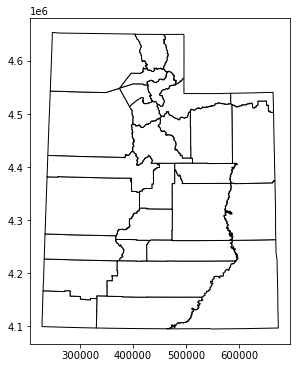

In [8]:
# Simple query to grab and plot Utah counties
sql = "select * from opensgid.boundaries.county_boundaries"
counties = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='shape')

counties.plot(figsize=(10, 6), color='white', edgecolor='black')

<AxesSubplot:>

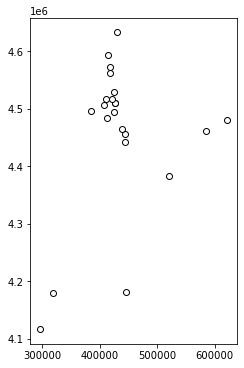

In [9]:
# Utah DAQ air monitoring stations 
sql_station = "select * from opensgid.environment.daq_air_monitor_by_station"
station = gpd.GeoDataFrame.from_postgis(sql_station, con, geom_col='shape')
#station.keys()

station.plot(figsize=(10, 6), color='white', edgecolor='black')

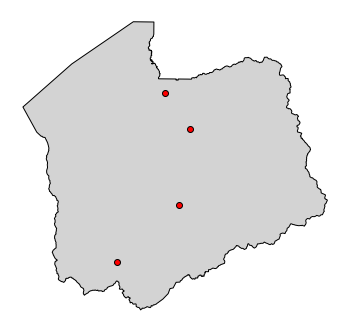

In [10]:
#SL county monitoring station by EPAID

sql_station = "select * from opensgid.environment.daq_air_monitor_by_station"
station = gpd.GeoDataFrame.from_postgis(sql_station, con, geom_col='shape')

sql_slc = "select * from opensgid.boundaries.county_boundaries where name = 'SALT LAKE'"
slc = gpd.GeoDataFrame.from_postgis(sql_slc, con, geom_col='shape')


stations = station[station['stationcounty'] == 'Salt Lake']
for i in ['MAGNA', 'Saltair', 'Hawthorne Annex']:
    stations = stations.drop(station[station['stationname'] == i].index)

fig, ax = plt.subplots(figsize=(6,6));
ax.axis('off');
slc.plot(ax=ax, color='lightgray', edgecolor='black');
# .plot(ax=ax, color='orange');
stations.plot(ax=ax, color='red', edgecolor='black');

In [11]:
# display a single day on the map as a gradient 
date = '1/1/20'

# filter each monitoring station DataFrame by the date
a = fdf_h3[fdf_h3['Date (Local)'] == date]
if len(a["Address"]) > 1:
    a = a[a["Address"] == a['Address'][0]][:1].copy()
a.replace(r'14058 Mirabella Dr.', r'14058 Mirabella Drive', inplace=True)

b = fdf_cv[fdf_cv['Date (Local)'] == date]
if len(b["Address"]) > 1:
    b = b[b["Address"] == b['Address'][0]][:1].copy()

c = fdf_rp[fdf_rp['Date (Local)'] == date]
if len(c["Address"]) > 1:
    c = c[c["Address"] == c['Address'][0]][:1].copy()
c.replace(r'1250 NORTH 1400 WEST', r'1400 W. Goodwin Ave.', inplace=True)

d = fdf_hw[fdf_hw['Date (Local)'] == date]
if len(d["Address"]) > 1:
    d = d[d["Address"] == d['Address'][0]][:1].copy()
d.replace(r'1675 SOUTH 600 EAST, SALT LAKE CITY', r'1675 S. 600 E.', inplace=True)

date_df = pd.concat((a, b, c, d)).reset_index()
date_df = date_df.rename(columns={'Address': 'stationaddress'})


/Users/evikarpos/opt/anaconda3/envs/geo_env/lib/python3.7/site-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [12]:
merged_df = pd.merge(stations, date_df, on="stationaddress")

# MERGE DATAFRAMES 

<AxesSubplot:>

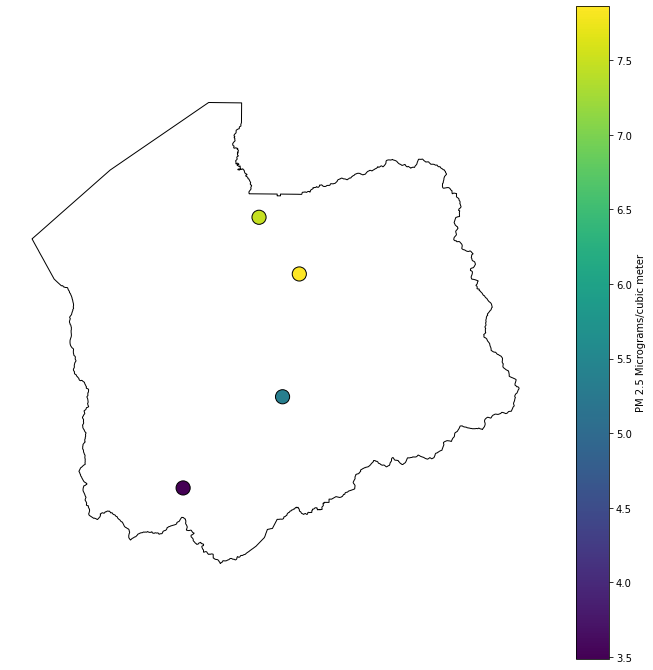

In [13]:
#Merged dataframes and SL County plot with graident of 2020 pm2.5 mean 

fig, ax = plt.subplots(figsize=(12,12));
ax.axis('off');

slc.plot(ax=ax, color='white', edgecolor='black');

merged_df.plot(ax=ax, 
               c=merged_df['Arithmetic Mean'],
               column='Arithmetic Mean',
               label=merged_df['stationid'],
               legend=True, 
               legend_kwds={'label': 'PM 2.5 Micrograms/cubic meter'}, 
               cmap='viridis',
               edgecolor='black',
               markersize=200)

#ax.text(10, 10)

## ADD IN MUNICIPALITIES 

In [14]:
counties = ["Salt Lake City", "Taylorsville", "Cottonwood Heights", "Draper",
            "West Valley City", "Sandy", "West Jordan", "South Jordan", "Murray", "Midvale", 
            "South Salt Lake", "Millcreek", "Herriman", "Riverton", "Holladay", "Magna", "Kearns",
           "Emigration Canyon"] 

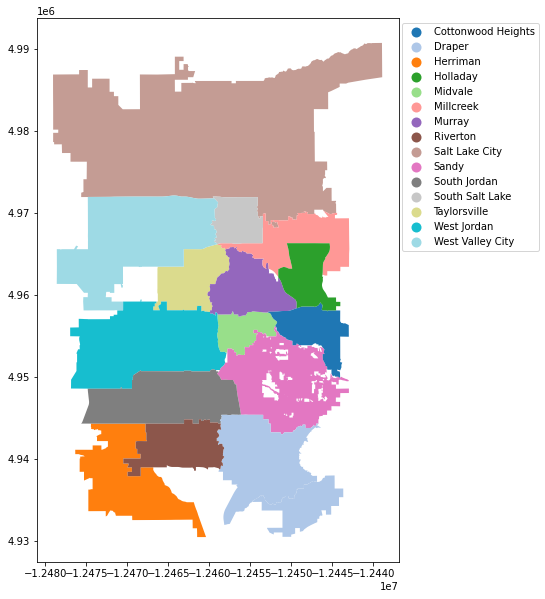

In [15]:
fp_0= os.path.join(base_path, "Utah_Municipal_Boundaries.shp")

fig, ax = plt.subplots(1,1, figsize=(20,10))
map_df = gpd.read_file(fp_0)
sl = map_df[map_df['NAME'].isin(counties)]
sl.plot(ax=ax, marker='o', column='NAME', categorical=True,
             markersize=100, legend=True, cmap='tab20');

# Adjust legend location
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.4,1))

# ADD TO COUNTY MAP

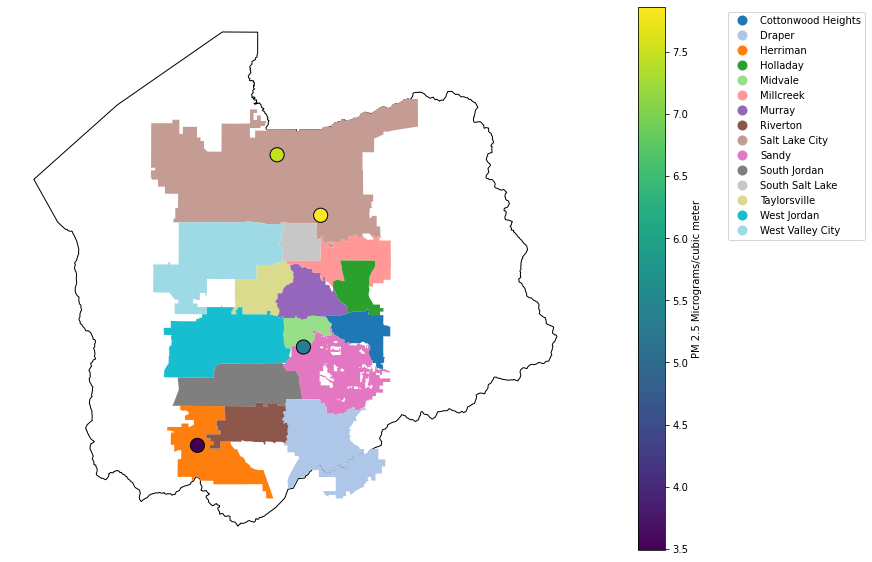

In [16]:
fig, ax = plt.subplots(1,1, figsize=(20,10))


map_df = gpd.read_file(fp_0)
sl = map_df[map_df['NAME'].isin(counties)]
slc.to_crs(epsg=3677).plot(ax=ax, color='white', edgecolor='black')
sl.to_crs(epsg=3677).plot(ax=ax,column='NAME', categorical=True, legend=True, cmap='tab20');
merged_df.to_crs(epsg=3677).plot(ax=ax, 
               c=merged_df['Arithmetic Mean'],
               column='Arithmetic Mean',
               label=merged_df['stationid'],
               legend=True, 
               legend_kwds={'label': 'PM 2.5 Micrograms/cubic meter'}, 
               cmap='viridis',
               edgecolor='black',
               markersize=200);
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5,1))
lims = plt.axis('off')

## MAKE GIF #1

The following code block makes an animation showing the PM-2.5 measurements for four monitoring stations across Salt Lake County.


In [17]:
# choose the date range of interest
dates = fdf_h3['Date (Local)'].copy()
date_range = pd.date_range(min(dates), max(dates), freq='MS') # 'MS' = month

months = ['January', 'Febuary', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']



for i, date in enumerate(date_range):
    # filter each monitoring station DataFrame by the date
    a = fdf_h3[fdf_h3['Date (Local)'] == date].reset_index()
    # if there are multiple addresses, choose the first index
    if len(a["Address"]) > 1:
        a = a[a["Address"] == a['Address'][0]][:1].copy()
    # replace the address with the correct one because we merged two DataFrame
    a.replace(r'14058 Mirabella Dr.', r'14058 Mirabella Drive', inplace=True)

    b = fdf_cv[fdf_cv['Date (Local)'] == date].reset_index()
    if len(b["Address"]) > 1:
        b = b[b["Address"] == b['Address'][0]][:1].copy()

    c = fdf_rp[fdf_rp['Date (Local)'] == date].reset_index()
    if len(c["Address"]) > 1:
        c = c[c["Address"] == c['Address'][0]][:1].copy()
    c.replace(r'1250 NORTH 1400 WEST', r'1400 W. Goodwin Ave.', inplace=True)

    d = fdf_hw[fdf_hw['Date (Local)'] == date].reset_index()
    if len(d["Address"]) > 1:
        d = d[d["Address"] == d['Address'][0]][:1].copy()
    d.replace(r'1675 SOUTH 600 EAST, SALT LAKE CITY', r'1675 S. 600 E.', inplace=True)

    # concatenate the 4 DatFrames
    date_df = pd.concat((a, b, c, d)).reset_index()
    date_df = date_df.rename(columns={'Address': 'stationaddress'})
    
    # merges the stations df with the date_df df
    merged_df = pd.merge(stations, date_df, on="stationaddress")
    
    
    # making the spatial plot for each month
    fig, ax = plt.subplots(figsize=(20,10));
    ax.axis('off');

    map_df_0 = gpd.read_file(fp_0)
    sl = map_df_0[map_df['NAME'].isin(counties)]
    slc.to_crs(epsg=3677).plot(ax=ax, color='white', edgecolor='black')
    sl.to_crs(epsg=3677).plot(ax=ax,column='NAME', categorical=True, legend=True, cmap='tab20');
    merged_df.to_crs(epsg=3677).plot(ax=ax, 
                   c=merged_df['Arithmetic Mean'],
                   column='Arithmetic Mean',
                   label=merged_df['stationid'],
                   legend=True, 
                   legend_kwds={'label': 'PM 2.5 Micrograms/cubic meter'}, 
                   cmap='viridis',
                   edgecolor='black',
                   markersize=200,
                   norm=plt.Normalize(vmin=3, vmax=5));
    ax.set_title(f"{months[i]} 2020")      # this adds month title 
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((1.5,1)) # this changes legend location
    chart = fig.get_figure()
    os.makedirs("pics", exist_ok=True)
    filepath = os.path.join(f"pics/{i:03d}.png")
    chart.savefig(filepath, dpi=300)
    fig.suptitle("Salt Lake County PM 2.5 Monthly Concentrations")
    plt.close()

In [18]:
# imageio is the method that makes gifs, movies, etc

fp = sorted(glob.glob(os.path.join("pics/*.png")))
frames = []
for f in fp:
    frames.append(imageio.imread(f))
imageio.mimwrite("timeseries.gif", frames, fps=1)

# MAKE SCATTER PLOT WITH MONITORING STATION DATA

In [19]:
#To help fix address issue. addresses were written differently in each file.

dates = fdf_h3['Date (Local)'].copy()
date_range = pd.date_range(min(dates), max(dates), freq='MS')


for i, date in enumerate(date_range):
    if i == 0:
        date_df = pd.DataFrame()
        
    # filter each monitoring station DataFrame by the date
    a = fdf_h3[fdf_h3['Date (Local)'] == date].reset_index()
    if len(a["Address"]) > 1:
        a = a[a["Address"] == a['Address'][0]][:1].copy()
    a.replace(r'14058 Mirabella Dr.', r'14058 Mirabella Drive', inplace=True)

    b = fdf_cv[fdf_cv['Date (Local)'] == date].reset_index()
    if len(b["Address"]) > 1:
        b = b[b["Address"] == b['Address'][0]][:1].copy()

    c = fdf_rp[fdf_rp['Date (Local)'] == date].reset_index()
    if len(c["Address"]) > 1:
        c = c[c["Address"] == c['Address'][0]][:1].copy()
    c.replace(r'1250 NORTH 1400 WEST', r'1400 W. Goodwin Ave.', inplace=True)

    d = fdf_hw[fdf_hw['Date (Local)'] == date].reset_index()
    if len(d["Address"]) > 1:
        d = d[d["Address"] == d['Address'][0]][:1].copy()
    d.replace(r'1675 SOUTH 600 EAST, SALT LAKE CITY', r'1675 S. 600 E.', inplace=True)

    address_df = pd.concat((a, b, c, d))
    date_df = pd.concat((date_df, address_df))


In [20]:
rose_park = date_df[date_df['Address'] == r'1400 W. Goodwin Ave.']
hawthorne = date_df[date_df['Address'] == r'1675 S. 600 E.']
midvale = date_df[date_df['Address'] == r'8449 S. Monroe St.']
herriman = date_df[date_df['Address'] == r'14058 Mirabella Drive']

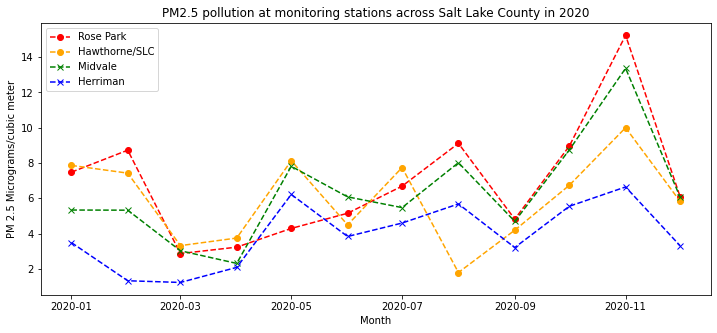

In [21]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
# ax1 = ax.twinx()

ax.plot(rose_park['Date (Local)'][:], rose_park['Arithmetic Mean'], '--o', color='red', label='Rose Park')
ax.plot(hawthorne['Date (Local)'][:], hawthorne['Arithmetic Mean'], '--o', color='orange', label='Hawthorne/SLC')
ax.plot(midvale['Date (Local)'][:], midvale['Arithmetic Mean'], '--x', color='green', label='Midvale')
ax.plot(herriman['Date (Local)'][:], herriman['Arithmetic Mean'], '--x', color='blue', label='Herriman')


ax.legend()
ax.set_ylabel('PM 2.5 Micrograms/cubic meter')
ax.set_xlabel('Month')
ax.set_title('PM2.5 pollution at monitoring stations across Salt Lake County in 2020')
ax.legend()

# CREATE POPULATION DATAFRAME FROM CENSUS DATA

In [22]:
# ended up grabbing more information online 
# source - US Census Data

# Rose Park - Pop: 34326
# White 30% - Hispanic 50% - Asian 5% - African American 5% - Hawaiian or other Pacific Islander 2% 

#Salt Lake City/Hawthorne - pop: 197,756
# White 65% - Hispanic 22% - Asian 5% - African American 2% - Hawaiian or other Pacific Islander 2% 

#Midvale CV - pop: 33,318
# White 64% -  Hispanic 25% - Asian 4% - African American 3% - Hawaiian or other Pacific Islander 1%

# Herriman - Pop: 40,149
# White 84% - Hispanic 7% - Hawaiian or other Pacific Islander 2% - Asian 1% - African American 1%

In [23]:
pop_dict = {'Rose_Park': {
                'total_population':34326, 
                'white': 34326*0.30,
                'hispanic': 34326*0.50}, 
    
            'Hawthorne': {'total_population': 197756, 
                'white': 197756*0.65,
                'hispanic': 197756*0.22},
            
             'Midvale': {'total_population': 33318, 
                'white': 33318*0.64,
                'hispanic': 33318*0.25},
            
            'Herriman': {'total_population': 40149, 
                'white': 40149*0.84,
                'hispanic': 40149*0.07}}

# MAKE BAR GRAPH WITH POPUALTION DATA

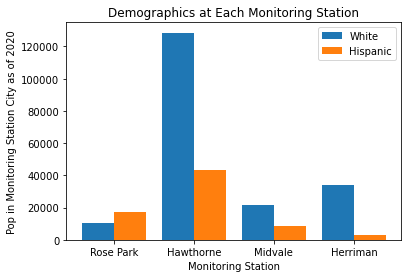

In [24]:
x = ['Rose Park', 'Hawthorne', 'Midvale', 'Herriman']
ywhite = np.array([pop_dict['Rose_Park']['white'],
                           pop_dict['Hawthorne']['white'],
                           pop_dict['Midvale']['white'],
                           pop_dict['Herriman']['white']])

xhispanic = np.array([pop_dict['Rose_Park']['hispanic'],
                              pop_dict['Hawthorne']['hispanic'],
                              pop_dict['Midvale']['hispanic'],
                              pop_dict['Herriman']['hispanic']])

x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, ywhite, 0.4, label = 'White')
plt.bar(x_axis +0.2, xhispanic, 0.4, label = 'Hispanic')
                   

plt.xticks(x_axis, x)
plt.xlabel("Monitoring Station")
plt.ylabel("Pop in Monitoring Station City as of 2020")
plt.title("Demographics at Each Monitoring Station")
plt.legend()
plt.show()